In [ ]:
!pip install calmap
!pip install squarify

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as graph
import calmap
import squarify

from datetime import datetime
from matplotlib.ticker import PercentFormatter
from matplotlib.colors import ListedColormap

In [21]:
import matplotlib as mpl
import pickle
import plotly.graph_objs as go
import plotly.express as px

mpl.rcParams['xtick.color'] = '#FEF4E8'
mpl.rcParams['ytick.color'] = '#FEF4E8'
mpl.rcParams['axes.labelcolor'] = '#FEF4E8'
mpl.rcParams['axes.facecolor'] = '#FEF4E8'
mpl.rcParams['axes.edgecolor'] = '#FEF4E8'
mpl.rcParams['font.size'] = '18'
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['axes.titlecolor'] = '#FEF4E8'

In [40]:
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

In [4]:
def prepare_df(fname):
  '''
  Reads data from flights.csv, removes empty/contradicting values, and then adds
  new columns (datetime objects, combined and separate delays).

  :param fname: filename (e.g. 'flights.csv')
  :type fname: str

  Returns:
  cleaned dataframe with new columns as described above.
  '''
  assert isinstance(fname, str)

  df = pd.read_csv(fname)                                                         # Read in data
  df = df[df.ORIGIN_AIRPORT.apply(lambda val: not isinstance(val, int))]          # Remove non-int values
  df = df[df.DESTINATION_AIRPORT.apply(lambda val: not isinstance(val, int))]     
  df = df.iloc[:, 0:24]                                                           # Only get first 24 cols as last few cols are very sparse
  df.dropna(inplace=True)                                                         # Drop NaN
  df['DATETIME'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
  df['DELAY'] = np.select([df['DEPARTURE_DELAY'] > 0, df['ARRIVAL_DELAY'] > 0], [1, 1], default=0)
  df['ARR_DELAY'] = np.where(df['ARRIVAL_DELAY'] > 0, 1, 0)
  df['DEP_DELAY'] = np.where(df['DEPARTURE_DELAY'] > 0, 1, 0)
  return df

In [5]:
df = prepare_df('flights.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [6]:
def plot_hist(col, xlabel, ylabel, title):
  '''
  Plot histogram of df column (used for delay columns) with column mean highlighted.

  :param col: column of dataframe df
  :type col: pd.Series
  :param xlabel: x-axis label
  :type xlabel: str
  :param ylabel: y-axis label
  :type ylabel: str
  :param title: title of plot
  :type title: str

  Returns:
  Plot showing histogram and mean of dataframe column.
  '''
  assert isinstance(col, pd.Series) and all(col.apply(float.is_integer))
  assert all([isinstance(x, str) for x in [xlabel, ylabel, title]])

  # Get statistics for column
  mean = col.mean()
  std = col.std()
  total = col.value_counts().to_dict()
  min_thresh = int(mean - 2*std)
  max_thresh = int(mean + 2*std)

  # Settings
  plt.rcParams['font.size'] = '18'
  with plt.rc_context({'axes.edgecolor':'#FEF4E8',
                       'xtick.color':'#FEF4E8',
                       'ytick.color':'#FEF4E8',}):
    plt.figure(figsize=(8,6))
    ax = plt.axes()
    ax.set_facecolor('#FEF4E8')

    # Plot
    plt.hist(col, color='salmon',density=True, bins=list(range(min_thresh, max_thresh)))
    plt.axvline(mean, color='deepskyblue', label='Mean', linestyle='--', linewidth=3.0)
    plt.legend(loc="upper left")
    min, max = plt.gca().get_ylim()
    plt.text(mean+5, max/2, f'{mean:.2f} minutes', color='deepskyblue')

    # Labels
    plt.xlabel(xlabel, color='#FEF4E8')
    plt.ylabel(ylabel, color='#FEF4E8')
    plt.title(title, color='#FEF4E8')

    
    plt.show()

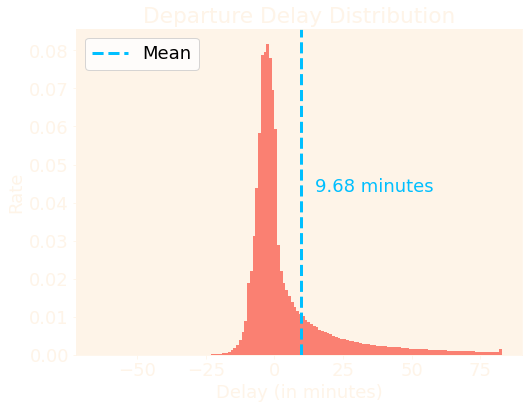

In [7]:
xlabel = 'Delay (in minutes)'
ylabel = 'Rate'
title = 'Departure Delay Distribution'
plot_hist(df.DEPARTURE_DELAY, xlabel, ylabel, title)

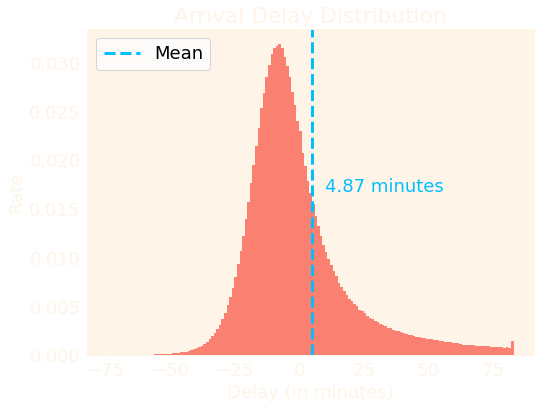

In [8]:
xlabel = 'Delay (in minutes)'
ylabel = 'Rate'
title = 'Arrival Delay Distribution'
plot_hist(df.ARRIVAL_DELAY, xlabel, ylabel, title)

In [11]:
def plot_by_state(title, df, airport_fname):
  '''
  Plot USA choropleth map to show delays per state.

  :param title: title of plot
  :type title: str
  :param df: dataframe
  :type df: pd.DataFrame
  :param airport_fname: filename of airport csv file (airports.csv)
  :type airport_fname: str 

  Returns:
  Choropleth plot showing delays per state
  '''
  assert isinstance(title, str) and isinstance(airport_fname, str)
  assert isinstance(df, pd.DataFrame)

  # Get state data to dataframe
  airport_df = pd.read_csv(airport_fname)
  state_dict = airport_df.set_index('IATA_CODE').to_dict()['STATE']
  df['ORIGIN_STATE'] = df['ORIGIN_AIRPORT'].map(state_dict)

  # Create new dataframe with state and associated densities
  delay = df.loc[df.DELAY==1]
  counts_dict = {'State': delay.ORIGIN_STATE.value_counts().index.to_list(), 
                'Density': delay.ORIGIN_STATE.value_counts().to_list()
                }
  state_to_counts = pd.DataFrame.from_dict(counts_dict)


  # Plot choropleth using plotly
  map_plot = graph.Figure(
    data=graph.Choropleth(
      locations=state_to_counts['State'],
      z = state_to_counts['Density'],
      locationmode = 'USA-states',
      colorscale = 'YlOrBr',
      marker_line_color='white',
      colorbar_title = "Delay rate"),
    layout= graph.Layout(
        geo_scope='usa',
        title = title,
        font = {"size": 10, "color":'#FEF4E8'},
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)'
    ))
  map_plot.show()

In [12]:
title = 'Density of Flight Delays for U.S. States'
plot_by_state(title, df, 'airports.csv')

In [13]:
def plot_by_date(xlabel, ylabel, title, df):
  '''
  Plots sliding window time series of dates and shows the densities of delays for each date.

  :param xlabel: x-axis label
  :type xlabel: str
  :param ylabel: y-axis label
  :type ylabel: str
  :param title: title of plot
  :type title: str
  :param df: dataframe
  :type df: pd.DataFrame

  Returns:
  Time series plot showing delays correlated with dates.
  '''
  assert all([isinstance(x, str) for x in [xlabel, ylabel, title]])
  assert isinstance(df, pd.DataFrame)

  # Get delay densities per datetime and approx. over sliding window
  delay = df.loc[df.DELAY==1]
  counts_dict = {'Datetime': delay.DATETIME.value_counts().index.to_list(), 
                'Num': delay.DATETIME.value_counts().to_list()
                }
  dates_to_counts = pd.DataFrame.from_dict(counts_dict)
  dates_to_counts = dates_to_counts.sort_values(by=['Datetime'])
  dates_to_counts['Sliding'] = dates_to_counts['Num'].rolling(14, min_periods=1).mean()

  # Convert to percentages
  total = dates_to_counts['Sliding'].sum()
  dates_to_counts['Sliding'] = dates_to_counts['Sliding'].apply(lambda x: 100*x/total)

  # Settings
  plt.rcParams['font.size'] = '18'
  with plt.rc_context({'axes.edgecolor':'#FEF4E8',
                        'xtick.color':'#FEF4E8',
                        'ytick.color':'#FEF4E8'}):
    
    # Plot actual datetime data
    plt.figure(figsize=(18,5))
    markers = [datetime(2015, 1, 1), datetime(2015, 5, 23), datetime(2015, 7, 3), datetime(2015, 9, 7), datetime(2015, 11, 26), datetime(2015, 12, 25)]
    with sns.axes_style(rc={'axes.facecolor':'#FEF4E8'}):
      sns.lineplot(x='Datetime', y='Sliding', data=dates_to_counts, label='Delay rate', color='deepskyblue')

    # Mark holidays and spans of vacations (march break, summer break, winter break)
    for date in markers:
      plt.axvline(date, color='deepskyblue', linewidth=2.0, linestyle='--')
    plt.axvspan(datetime(2015, 3, 1), datetime(2015, 3, 21), color='yellowgreen', alpha=0.4, lw=0)
    plt.axvspan(datetime(2015, 6, 22), datetime(2015, 8, 31), color='orangered', alpha=0.4, lw=0)
    plt.axvspan(datetime(2015, 12, 15), datetime(2015, 12, 31), color='deepskyblue', alpha=0.4, lw=0)
    plt.axvspan(datetime(2015, 1, 1), datetime(2015, 1, 4), color='deepskyblue', alpha=0.4, lw=0)

    plt.xlabel(xlabel, color='#FEF4E8')
    plt.ylabel(ylabel, color='#FEF4E8')
    plt.title(title, color='#FEF4E8')

    plt.show()

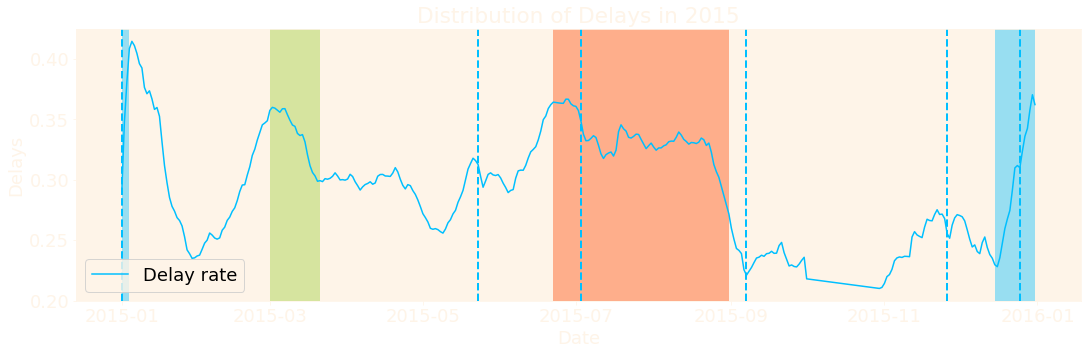

In [14]:
xlabel = 'Date'
ylabel = 'Delays'
title = 'Distribution of Delays in 2015'
plot_by_date(xlabel, ylabel, title, df)

In [15]:
def plot_square(df, month=True):
  '''
  Plots square map of delays for each month or weekday.

  :param df: dataframe
  :type df: pd.DataFrame
  :param month: flag for plotting month or weekday
  :type month: bool

  Returns:
  Plots square map showing proportion of delays.
  '''
  assert isinstance(df, pd.DataFrame) 
  assert isinstance(month, bool)

  delay = df.loc[df.DELAY==1]
  if month:
    counts = delay.MONTH.value_counts().sort_index().to_list()
    total = sum(counts)
    counts = [100*x/total for x in counts]
    labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    labels = [labels[i] + '\n' + f'{counts[i]:.2f}' + '%' for i in range(12)]
  else:
    counts = delay.DAY_OF_WEEK.value_counts().sort_index().to_list()
    total = sum(counts)
    counts = [100*x/total for x in counts]
    labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    labels = [labels[i] + '\n' + f'{counts[i]:.2f}' + '%' for i in range(7)]

  cmap = plt.get_cmap('autumn')
  plt.figure(figsize=(12,6))
  squarify.plot(counts, color=cmap(counts/(0.5*np.linalg.norm(counts))), label=labels, pad=True)
  if month:
    plt.title('Delay Percentages per Month in 2015',color='#FEF4E8')
  else:
    plt.title('Delay Percentages per Weekday in 2015',color='#FEF4E8')

  plt.axis('off')
  plt.show()

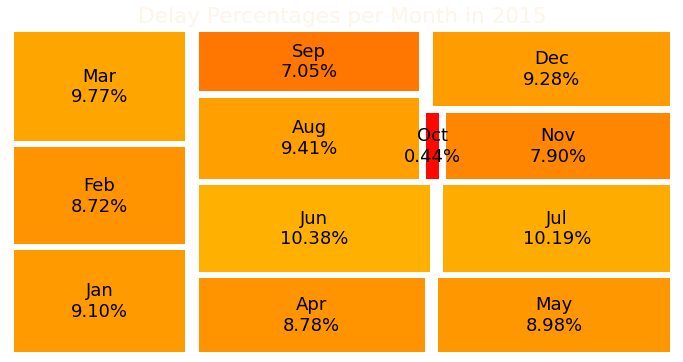

In [16]:
plot_square(df)

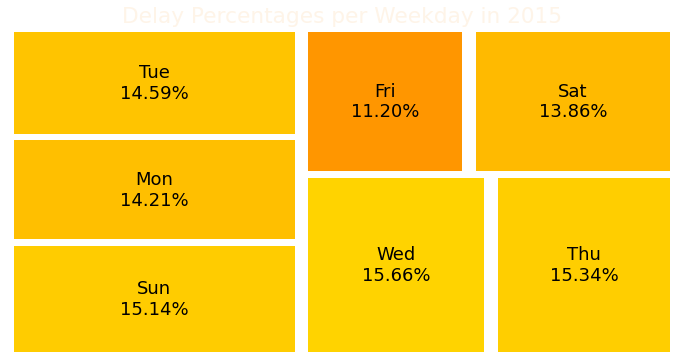

In [17]:
plot_square(df, month=False)

In [18]:
def share_pie(df):
  '''
  Plots pie chart of each airline's share within the dataset

  :param df: dataframe
  :type df: pd.DataFrame

  Returns:
  Plots pie chart of airline representation
  '''
  assert isinstance(df, pd.DataFrame) 
  cmap = ['#fa8072', '#87cefa', '#f5a700', '#eb471a', '#086569', '#936400','#ac9e81','#d60800', '#E9D6EC', '#B8336A','#63A375','#e4bb95','#d5c4a1','#c8524e']
  delay2 = df.groupby(['AIRLINE']).count()
  delay2 = delay2[['DELAY']]
  delay2.columns=['Market Share']
  delay2['Market Share'].sort_index()
  delay2 = delay2.sort_values(by = 'Market Share')

  df2 = delay2[4:].copy()
  df3 = delay2['Market Share'][:4]
  new_row = pd.DataFrame(data = {

      'Market Share' : [delay2['Market Share'][:4].sum()]
  })
  new_row = new_row.rename(index={new_row.index[-1]: 'Other'})

  df2 = pd.concat([df2, new_row])

  plot = df2.plot.pie(y='Market Share',autopct='%1.2f%%', pctdistance=1.4, labels=['','','','','','','','','','',''],colors=cmap,textprops={'color':'#FEF4E8'},wedgeprops={'linewidth': 1, 'antialiased': True})
  plt.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0, labels=['Alaska Airlines Inc.','American Eagle Airlines Inc.','JetBlue Airways','US Airways Inc.','United Air Lines Inc.','Atlantic Southeast Airlines','American Airlines Inc.','Skywest Airlines Inc.','Delta Air Lines Inc.','Southwest Airlines Co.','Other'])

  plt.title(' ',color='#FEF4E8')

  plt.xlabel('', )
  plt.ylabel('', )

  plt.show()

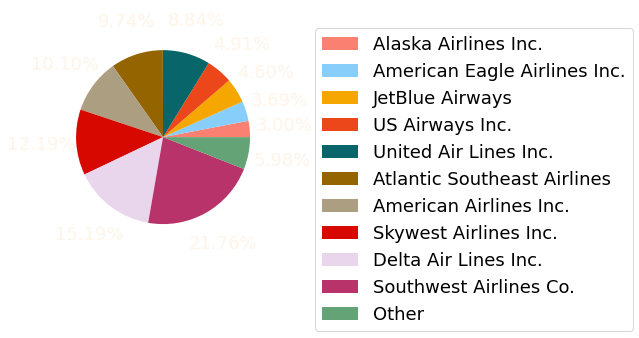

In [19]:
share_pie(df)

In [22]:
discrete_cmap = ['#fa8072', '#87cefa', '#f5a700', '#eb471a', '#086569',
                 '#936400', '#ac9e81', '#d60800', '#13e2ea', '#66c2a5', '#d60800', '#e4bb95', '#d5c4a1', '#c8524e']
with open("cmap.dat", "rb") as f:
    cmap = pickle.load(f)


In [23]:
def read_clean_df(flights="/content/drive/MyDrive/flights.csv", airline="/content/drive/MyDrive/airlines.csv", airport="/content/drive/MyDrive/airports.csv"):
    """
    Read data from file, clean it by removing invalid rows and add columns('DELAY', 'ARR_DELAY', 'DEP_DELAY')

    Args:
        flights (str, optional): filepath for flights data. Defaults to "/content/drive/MyDrive/flights.csv".
        airline (str, optional): filepath for flights data. Defaults to "/content/drive/MyDrive/airlines.csv".
        airport (str, optional): filepath for airport data. Defaults to "/content/drive/MyDrive/airports.csv".

    Returns:
        df, df_airline, df_airport(pd.DataFrame): cleaned dataframe
    """
    assert isinstance(flights, str)
    assert isinstance(airline, str)
    assert isinstance(airport, str)

    df = pd.read_csv("flights.csv",
                     dtype={'ORIGIN_AIRPORT': str, 'DESTINATION_AIRPORT': str})
    df = df.drop(df[df['ORIGIN_AIRPORT'].str.isdigit()].index, axis=0)
    tmp = df[df['CANCELLATION_REASON'].isnull()].iloc[:, 0:24]
    df = df.drop(tmp[tmp.isnull().any(axis=1)].index, axis=0)
    df.reset_index(inplace=True, drop=True)
    df['DELAY'] = np.select(
        [df['DEPARTURE_DELAY'] > 0, df['ARRIVAL_DELAY'] > 0], [1, 1], default=0)
    df['ARR_DELAY'] = np.where(df['ARRIVAL_DELAY'] > 0, 1, 0)
    df['DEP_DELAY'] = np.where(df['DEPARTURE_DELAY'] > 0, 1, 0)

    df_airline = pd.read_csv("airlines.csv")

    df_airport = pd.read_csv("airports.csv")
    df_airport = df_airport.drop(
        df_airport[df_airport.isnull().any(axis=1)].index, axis=0)

    df['AIRLINE'] = df['AIRLINE'].map(
        df_airline.set_index('IATA_CODE')['AIRLINE'])

    return df, df_airline, df_airport


In [24]:
df, df_airline, df_airport = read_clean_df(
    "flights.csv", "airlines.csv", "airports.csv")


In [25]:
df = df.drop(df[df['CANCELLED'] == 1].index, axis=0)


In [26]:
def plot_airline_delay(df, xlabel, ylabel):
    """
    Average Departure Delay vs. Average Arrival Delay

    Args:
        df (pd.DataFrame): dataframe of flights
        xlabel (str): x-axis label
        ylabel (str): y-axis label
    """
    assert isinstance(df, pd.DataFrame)
    assert isinstance(xlabel, str)
    assert isinstance(ylabel, str)

    # get statistics
    df['departute_hour'] = np.floor(
        (df['SCHEDULED_DEPARTURE']-1)/100).astype(np.int8)
    df['arrival_hour'] = np.floor(
        (df['SCHEDULED_ARRIVAL']-1)/100).astype(np.int8)

    df_delay_airline = pd.DataFrame(df[df['DELAY'] == 1].groupby(['AIRLINE']).size(
    )/df.groupby(['AIRLINE']).size(), columns=['delay_rate']).reset_index()
    df_delay_airline = df_delay_airline.sort_values(by=['delay_rate'])
    df_delay_airline['higher_than_avg'] = np.where(
        df_delay_airline['delay_rate'] > df_delay_airline['delay_rate'].mean(), 'Higher than average', 'Lower than average')

    # plot
    _, ax = plt.subplots(figsize=(10, 10))
    fig = sns.barplot(x="delay_rate", y="AIRLINE", data=df_delay_airline,
                      hue='higher_than_avg', palette=['#eb471a', '#f5a700'])
    fig.legend(loc="upper right")

    # labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axvline(df_delay_airline['delay_rate'].mean(
    ), color='deepskyblue', label='Mean', linestyle='--', linewidth=2.0)

    return df


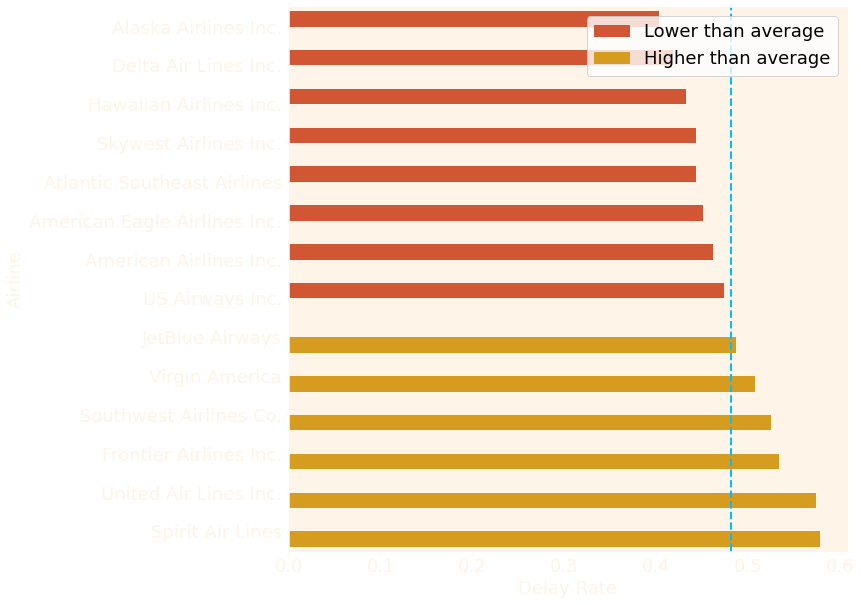

In [27]:
df = plot_airline_delay(df, 'Delay Rate', 'Airline')


In [28]:
def plot_heatmap1(df, xlabel, ylabel, title):
    """
    Delays Rate vs. Airline and Arrival Hour

    Args:
        df (pd.DataFrame): dataframe of flights
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        title (str): title of plot
    """
    assert isinstance(df, pd.DataFrame)
    assert isinstance(xlabel, str)
    assert isinstance(ylabel, str)
    assert isinstance(title, str)

    df_rate_arr = pd.DataFrame(df[df['DELAY'] == 1].groupby(['arrival_hour', 'AIRLINE']).size(
    )/df.groupby(['arrival_hour', 'AIRLINE']).size(), columns=['delay_rate'])
    df_rate_arr = df_rate_arr.pivot_table(
        'delay_rate', index='AIRLINE', columns='arrival_hour')
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.heatmap(df_rate_arr[range(6, 24)], cmap='Wistia', ax=ax,
                linecolor='white', linewidth=0.01, cbar_kws={'label': 'Delay Rate'})

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


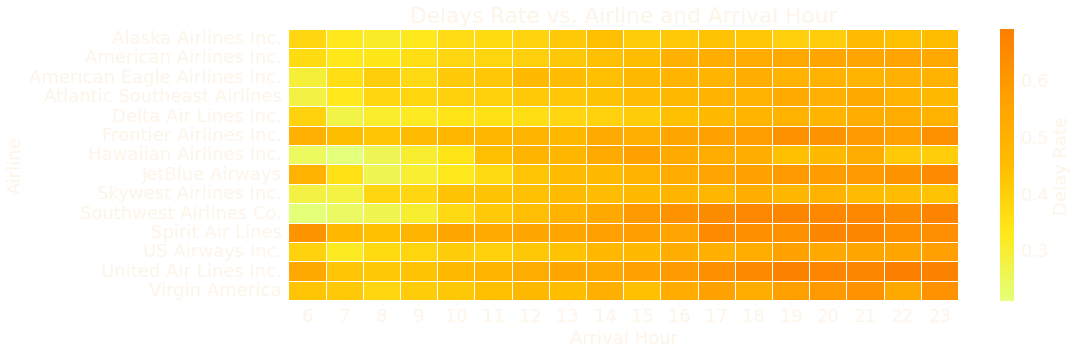

In [29]:
plot_heatmap1(df, 'Arrival Hour', 'Airline',
              'Delays Rate vs. Airline and Arrival Hour')


In [30]:
def plot_heatmap2(df, xlabel, ylabel, title):
    """
    Delays Rate vs. Airline and Departute Hour

    Args:
        df (pd.DataFrame): dataframe of flights
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        title (str): title of plot
    """
    assert isinstance(df, pd.DataFrame)
    assert isinstance(xlabel, str)
    assert isinstance(ylabel, str)
    assert isinstance(title, str)

    df_rate_arr = pd.DataFrame(df[df['DELAY'] == 1].groupby(['departute_hour', 'AIRLINE']).size(
    )/df.groupby(['departute_hour', 'AIRLINE']).size(), columns=['delay_rate'])
    df_rate_arr = df_rate_arr.pivot_table(
        'delay_rate', index='AIRLINE', columns='departute_hour')
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.heatmap(df_rate_arr[range(6, 24)], cmap='Wistia', ax=ax,
                linecolor='white', linewidth=0.01, cbar_kws={'label': 'Delay Rate'})

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)


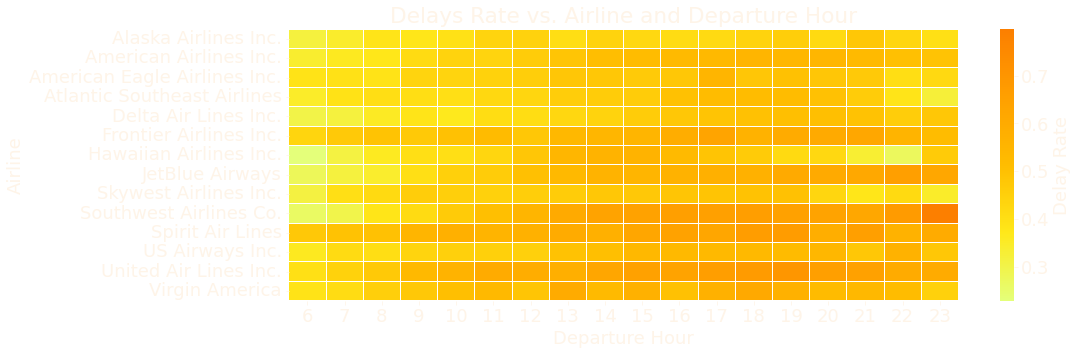

In [31]:
plot_heatmap2(df, 'Departure Hour', 'Airline',
              'Delays Rate vs. Airline and Departure Hour')


In [32]:
def plot_reasons_delay(df, title):
    """
    pie chart for reasons for delay

    Args:
        df (pd.DataFrame): dataframe of flights
        title (str): title of plot
    """
    assert isinstance(df, pd.DataFrame)
    assert isinstance(title, str)

    # get statistics
    df_delay_type = pd.Series([len(df[df['AIR_SYSTEM_DELAY'] > 0]), len(df[df['SECURITY_DELAY'] > 0]),
                               len(df[df['AIRLINE_DELAY'] > 0]), len(
                               df[df['LATE_AIRCRAFT_DELAY'] > 0]),
                               len(df[df['WEATHER_DELAY'] > 0])],
                              ['air_system', 'security', 'airline', 'late_aircraft', 'weather'])

    # plot
    fig, ax = plt.subplots(figsize=(10, 10))
    patches, texts, pcts = ax.pie(df_delay_type, labels=['Air System', 'Security', 'Airline', 'Late Aircraft', 'Weather'],
                                  autopct='%1.1f%%', colors=discrete_cmap)

    # labels
    for i in range(len(texts)):
        texts[i].set_color('#FEF4E8')

    plt.title(title)
    plt.setp(pcts, color='#FEF4E8')


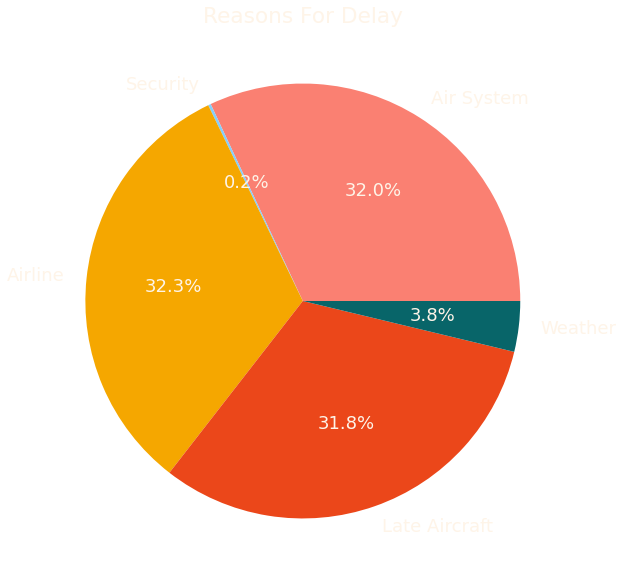

In [33]:
plot_reasons_delay(df, "Reasons For Delay")


In [34]:
def get_color(cmap, position):
    """
    get RGB color from color map

    Args:
        cmap (mpl.colors.LinearSegmentedColormap): color map
        position (): position on the color map (between 0 and 1)

    Returns:
        str: represents rgb color that can be used in plotly
    """
    assert isinstance(cmap, mpl.colors.LinearSegmentedColormap)
    assert 0 <= position <= 1

    color = cmap(position)
    return f"rgb({int(round(color[0]*255))},{int(round(color[1]*255))},{int(round(color[2]*255))})"


In [35]:
def plot_route_airport(df, df_airport, title):
    """
    plot route and aiport on map as well as delay rate

    Args:
        df (pd.DataFrame): dataframe of flights
        df_airport (pd.DataFrame): dataframe of airport
        title (str): title of plot
    """
    assert isinstance(df, pd.DataFrame)
    assert isinstance(df_airport, pd.DataFrame)
    assert isinstance(title, str)

    # get statistics
    df['route'] = tuple(zip(df['ORIGIN_AIRPORT'], df['DESTINATION_AIRPORT']))
    df['route'] = df['route'].apply(sorted)
    df['route'] = df['route'].apply(tuple)

    df['latitude_origin'] = df['ORIGIN_AIRPORT'].map(
        df_airport.set_index('IATA_CODE')['LATITUDE'])
    df['latitude_des'] = df['DESTINATION_AIRPORT'].map(
        df_airport.set_index('IATA_CODE')['LATITUDE'])

    df_route = pd.DataFrame(df.groupby(['route']).size(), columns=['count'])
    df_route = df_route[df_route['count'] > 5000].reset_index()
    df_route['origin'], df_route['destination'] = zip(*df_route['route'])
    df_route['latitude_origin'] = df_route['origin'].map(
        df_airport.set_index('IATA_CODE')['LATITUDE'])
    df_route['longtitude_origin'] = df_route['origin'].map(
        df_airport.set_index('IATA_CODE')['LONGITUDE'])
    df_route['latitude_des'] = df_route['destination'].map(
        df_airport.set_index('IATA_CODE')['LATITUDE'])
    df_route['longtitude_des'] = df_route['destination'].map(
        df_airport.set_index('IATA_CODE')['LONGITUDE'])

    df_route['count_delay'] = df_route['route'].map(
        df[df['DELAY'] == 1].groupby(['route']).size())

    df_route['delay_rate'] = df_route['count_delay']/df_route['count']
    df_route = df_route[df_route['delay_rate'] < 0.67].reset_index(drop=True)

    df_airport['delay_rate'] = df_airport['IATA_CODE'].map(df[df['DELAY'] == 1].groupby(
        'ORIGIN_AIRPORT').size()/df.groupby('ORIGIN_AIRPORT').size())
    df_airport['count'] = df_airport['IATA_CODE'].map(
        df.groupby('ORIGIN_AIRPORT').size())
    df_airport = df_airport[df_airport['count'] > 10000].reset_index(drop=True)

    # plot
    c_min, c_max = min(df_route['delay_rate']), max(df_route['delay_rate'])
    fig = px.scatter_mapbox(df_airport, lat="LATITUDE", lon="LONGITUDE", color="delay_rate", size="count", range_color=[c_min, c_max],
                            color_continuous_scale=['#FFFFFF', '#FFFFFF', '#faed2d', '#ffce0a', '#ffb100', '#fe9900', '#FF7500'], size_max=20, zoom=3)

    fig.update_geos(projection_type="orthographic")
    for i in range(len(df_route)):
        p_of_cmap = (df_route['delay_rate'][i]-c_min)/(c_max-c_min)
        fig.add_trace(
            go.Scattermapbox(
                lon=[df_route['longtitude_origin'][i],
                     df_route['longtitude_des'][i]],
                lat=[df_route['latitude_origin'][i],
                     df_route['latitude_des'][i]],
                mode='lines',
                line=dict(width=1, color=get_color(cmap, p_of_cmap)),
                opacity=float(df_route['count'][i]) /
                float(df_route['count'].max()),
                showlegend=False,
            )
        )

    fig.update_layout(mapbox_accesstoken="pk.eyJ1IjoibGFsYWxhMjAyMSIsImEiOiJja3drNGl0djAxb2phMnVubzZkYWhmZ3hkIn0.TbWtnv71s5niti55m-KJ6g",
                      mapbox_style="light",
                      title=title,
                      font={"size": 10, "color": '#FEF4E8'},
                      plot_bgcolor='rgba(0,0,0,0)',
                      paper_bgcolor='rgba(0,0,0,0)'
                      )

    fig.update_coloraxes(colorbar_title_text='Delay Rate')

    fig.show()


In [36]:
plot_route_airport(df, df_airport, 'Delay Rate of Flights and Airports in US')


In [37]:
def plot_big_small_airport(df, df_airport, xlabel, ylabel, title):
    """
    Big/Small aiports

    Args:
        df (pd.DataFrame): dataframe of flights
        df_airport (pd.DataFrame): dataframe of airport
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        title (str): title of plot
    """
    assert isinstance(df, pd.DataFrame)
    assert isinstance(df_airport, pd.DataFrame)
    assert isinstance(xlabel, str)
    assert isinstance(ylabel, str)
    assert isinstance(title, str)

    df_airport['delay_rate'] = df_airport['IATA_CODE'].map(df[df['DELAY'] == 1].groupby(
        'ORIGIN_AIRPORT').size()/df.groupby('ORIGIN_AIRPORT').size())
    df_airport['count'] = df_airport['IATA_CODE'].map(
        df.groupby('ORIGIN_AIRPORT').size())
    df_airport['airport_size'] = np.where(
        df_airport['count'] > 20000, 'Big Airport', 'Small Airport')

    fig = sns.lmplot(x="count", y="delay_rate", fit_reg=False,
                     hue="airport_size", palette=['#eb471a', '#f5a700'],
                     data=df_airport)
    plt.axhline(y=0.4728, color='deepskyblue', linestyle='--')

    fig.fig.set_figheight(10)
    fig.fig.set_figwidth(13)
    fig.legend.set_title("")
    fig.legend.draw_frame(True)
    fig.set_xlabels(xlabel)
    fig.set_ylabels(ylabel)
    fig.set_titles(title)


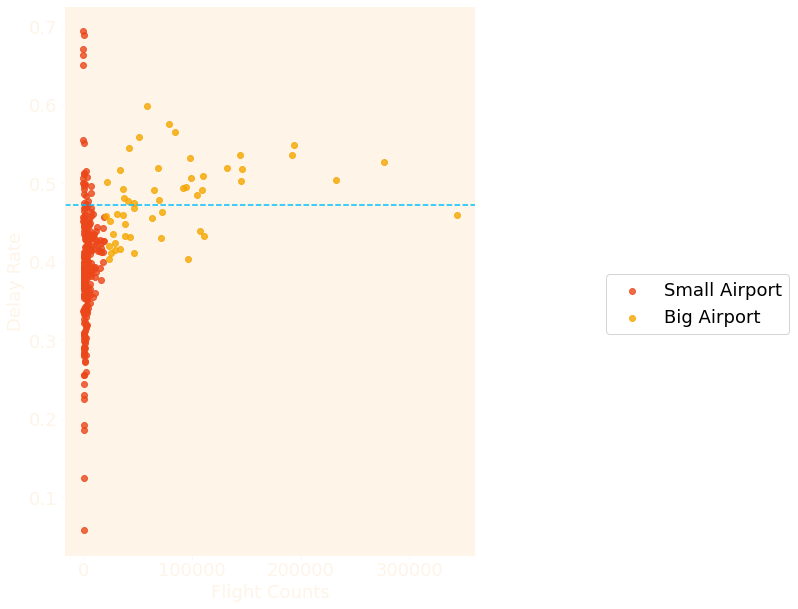

In [39]:
plot_big_small_airport(df, df_airport, "Flight Counts",
                       "Delay Rate", "Big/Small aiports")


In [41]:
# Load data and pre-processing 
df = pd.read_csv('flights.csv', low_memory = False)
df['AIR_ROUTE'] = df['AIRLINE'] + df['FLIGHT_NUMBER'].astype(str)
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

data = df[: 1000000]
data = data.fillna(data.mean(numeric_only=True))
data_fd = data[data['CANCELLED'] == 0]
data_fd = data_fd.drop(['CANCELLED'], axis = 1)

data_fd.loc[:, 'ORIGIN_AIRPORT'] = data_fd['ORIGIN_AIRPORT'].astype('category').cat.codes
data_fd.loc[:, 'DESTINATION_AIRPORT'] = data_fd['DESTINATION_AIRPORT'].astype('category').cat.codes
data_fd.loc[:, 'AIR_ROUTE'] = data_fd['AIR_ROUTE'].astype('category').cat.codes
data_fd.loc[:, 'DATE'] = data_fd['DATE'].astype('category').cat.codes

# Add DELAY to dataframe
# NO DELAY : 0
# DELAY : 1
DELAY = np.zeros_like(data_fd['ARRIVAL_DELAY'])
DELAY[np.logical_or(data_fd['ARRIVAL_DELAY'] > 0, data_fd['DEPARTURE_DELAY'] > 0)] = 1
data_fd.loc[:, 'DELAY'] = DELAY

# # Add DELAY_TIME to dataframe
# NO DELAY : 0
# DELAY 0 - 15 MIN: 1
# DELAY 15 - 30 MIN: 2
# DELAY 30 - 45 MIN: 3
# DELAY 45 - 60 MIN: 4
# DELAY > 60 MIN: 5
DELAY_TIME = np.zeros_like(data_fd['ARRIVAL_DELAY'])
DELAY_TIME[np.logical_and(data_fd['ARRIVAL_DELAY'] <= 15, data_fd['ARRIVAL_DELAY'] > 0)] = 1
DELAY_TIME[np.logical_and(data_fd['ARRIVAL_DELAY'] <= 30, data_fd['ARRIVAL_DELAY'] > 15)] = 2
DELAY_TIME[np.logical_and(data_fd['ARRIVAL_DELAY'] <= 45, data_fd['ARRIVAL_DELAY'] > 30)] = 3
DELAY_TIME[np.logical_and(data_fd['ARRIVAL_DELAY'] <= 60, data_fd['ARRIVAL_DELAY'] > 45)] = 4
DELAY_TIME[data_fd['ARRIVAL_DELAY'] > 60] = 5
data_fd.loc[:, 'DELAY_TIME'] = DELAY_TIME

# Manually drop unrelated features
drop_col = []
drop_col += ['TAIL_NUMBER','TAXI_OUT','WHEELS_OFF',\
             'WHEELS_ON','TAXI_IN','CANCELLATION_REASON','ARRIVAL_TIME', \
             'DIVERTED','MONTH','YEAR','DAY','DAY_OF_WEEK', \
             'AIRLINE', 'FLIGHT_NUMBER', 'ELAPSED_TIME', \
             'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', \
             'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
data_f = data_fd.drop(list(set(drop_col)), axis = 1)

# colors = [(135/255, 206/255, 250/255), (1, 160/255, 122/255)] 
# color_map = LinearSegmentedColormap.from_list('blue2salmon', colors, N=10)
color_map = cm.get_cmap('Oranges')
font = {'family' : 'DejaVu Sans', 'weight' : 'bold', 'size' : 22}
plt.rc('font', **font)

In [42]:
def getCorrelationMat(df):
    
    '''
    Get the correlation matrix between selected features
    :param: df
    :type: panda.DataFrame
    '''
    
    assert isinstance(df, pd.DataFrame), 'INVALID INPUT TYPE'
    
    data_f = df
    f = plt.figure(figsize = (12, 12))
    plt.matshow(data_f.corr(), fignum = f.number, cmap = color_map)
    plt.xticks(np.arange(data_f.shape[1]) + 0.1, data_f.columns, fontsize=10, rotation=45, color = '#FEF4E8')
    plt.yticks(np.arange(data_f.shape[1]) + 0.1, data_f.columns, fontsize=10, color = '#FEF4E8')
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize = 12, color = '#FEF4E8')
    cbytick_obj = plt.getp(cb.ax.axes, 'yticklabels')
    plt.setp(cbytick_obj, color='#FEF4E8')
    plt.title('Correlation Matrix of Selected Features', fontsize = 28, fontweight='bold', y = -0.1, color = '#FEF4E8')
    plt.savefig('corr_mat.png', bbox_inches = 'tight')
    plt.show()
    

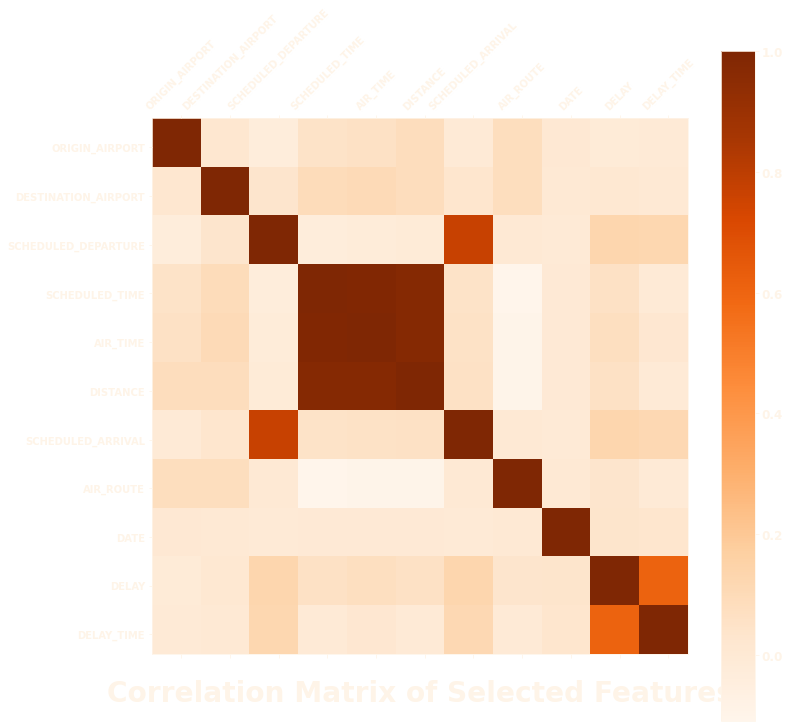

In [43]:
getCorrelationMat(data_f)

In [44]:
def getConfusionMat(model, model_name, X, y, classes):
    
    '''
    Display the confusion matrix of applying a classification model on the dataset, and print the accuracy rate
    :param: model
    :type: sklearn.tree._classes
    :param: model_name
    :type: str
    :param: X
    :type: numpy.ndarray
    :param: y
    :type: numpy.ndarray
    :param: classes
    :type: list
    '''
    
    assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) \
    and isinstance(model_name, str) and isinstance(classes, list), 'INVALID INPUT TYPE'
    assert X.shape[0] == y.shape[0] and y.shape[0] == np.size(y), 'INVALID INPUT SHAPE'
    for ele in classes: assert isinstance(ele, str), 'INVALID INPUT VALUE'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    scaled_features = StandardScaler().fit_transform(X_train, X_test)
    model = model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test) if len(classes) > 2 else model.predict(X_test)
    auc_score = metrics.roc_auc_score(y_test, y_pred, multi_class = 'ovr')
    print ('The accuracy rate is {} by using the {} classifier'.format(np.round(auc_score, 4), model_name))
    
    disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=classes,
            cmap=color_map,
            normalize='true',
            )
    
    class_type = 'Binary' if len(classes) == 2 else 'Multi-Class'
    title = 'Confusion Matrix for {} Classification ({})'.format(class_type, model_name)
    disp.ax_.set_title(title, color = '#FEF4E8', y = -0.2)
    plt.xlabel('Prediction Label', color = '#FEF4E8', fontweight = 'bold')
    plt.ylabel('True Label', color = '#FEF4E8', fontweight = 'bold')
    disp.ax_.tick_params(axis = 'x', colors = '#FEF4E8', labelsize = 18)
    disp.ax_.tick_params(axis = 'y', colors = '#FEF4E8', labelsize = 18)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 12)
    plt.show()



The accuracy rate is 0.6548 by using the Random Forest classifier


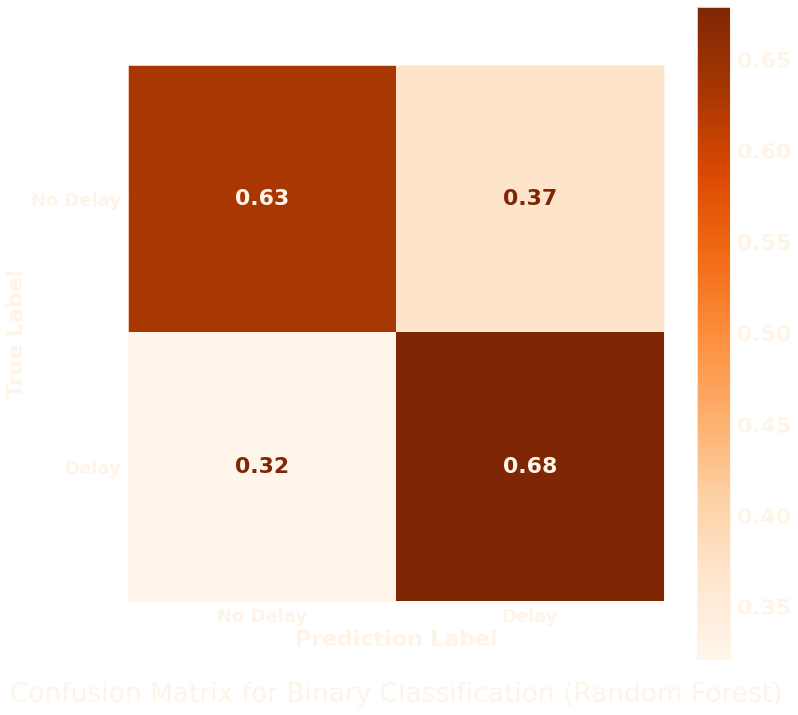

In [45]:
data_fml_bin = data_f.drop(['DELAY_TIME'], axis = 1)
data_bin = data_fml_bin.values
X, y = data_bin[:,:-1], data_bin[:,-1]
model = RandomForestClassifier(random_state = 42)
classes = ['No Delay', 'Delay']
getConfusionMat(model, 'Random Forest', X, y, classes)

The accuracy rate is 0.6758 by using the Random Forest classifier


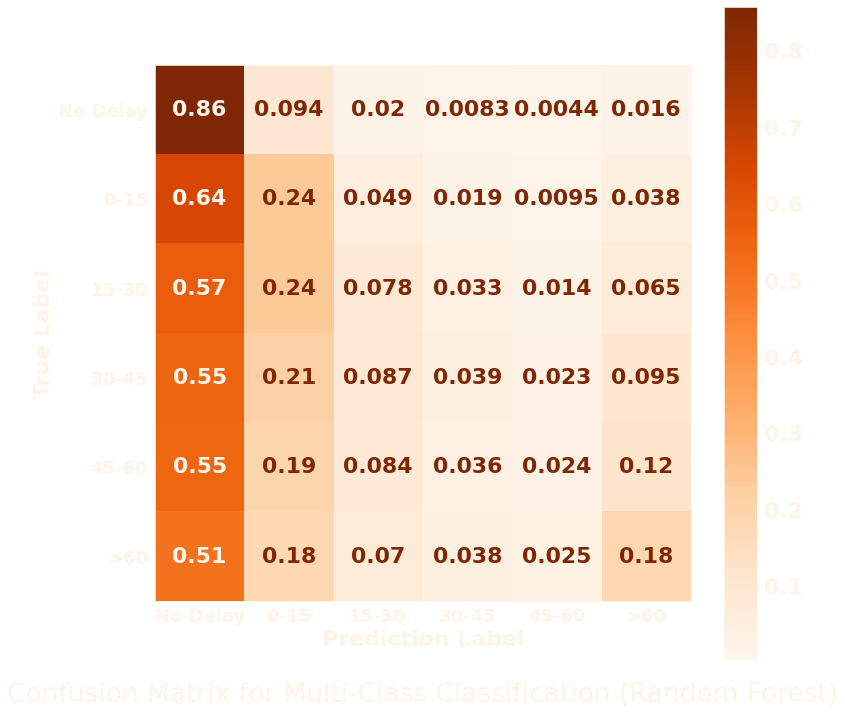

In [46]:
data_fml_mul = data_f.drop(['DELAY'], axis = 1)
data_mul = data_fml_mul.values
X, y = data_mul[:,:-1], data_mul[:,-1]
model = RandomForestClassifier(random_state = 42)
classes = ['No Delay', '0-15', '15-30', '30-45', '45-60', '>60']
getConfusionMat(model, 'Random Forest', X, y, classes)